<div style="text-align: center;"> 
    <span style="font-size: 40px; font-weight: bold">
        Lập trình cho Khoa học dữ liệu - CQ2023/21
    </span>
</div>

<div style="text-align: center;"> 
    <span style="font-size: 24px; font-weight: bold">
        <i>
            01. Data Exploration
        </i>
    </span>
</div>

<div style="text-align: center;"> 
    <span style="font-size: 18px">
            Nguyễn Lê Tấn Phát - 22120262
    </span>
</div>

<div style="text-align: right;">
    <span style="font-size: 14px">
        <i>
            Nov 22, 2025
        </i>
    </span>
</div>

---

<h1 align="center">
    <span style="font-size: 40px; font-weight: bold">
        Mục lục
    </span style>
</h1>

- [**I. Chuẩn bị thư viện**](#i)

- [**II. Chuẩn bị dữ liệu**](#ii)

- [**III. Kiểm tra phân bố lớp**](#iii)

    - [**1. Tập dữ liệu gốc**](#iii_1)

    - [**2. Undersampling**](#iii_2)

    - [**3. SMOTE**](#iii_3)

- [**IV. Khám phá đặc trưng Amount**](#iv)

    - [**1. Thống kê cơ bản**](#iv_1)

    - [**2. Phân bố trong các lớp**](#iv_2)

- [**V. Khám phá đặc trưng Time**](#v)

    - [**1. Thống kê cơ bản**](#v_1)

    - [**2. Phân bố trong các lớp**](#v_2)

- [**VI. Tương quan giữa các đặc trưng**](#vi)

    - [**1. Ma trận tương quan trên tập dữ liệu gốc**](#vi_1)

    - [**2. Ma trận tương quan trên tập dữ liệu cân bằng**](#vi_2)

- [**VII. Phân cụm**](#vii)

- [**VIII. Tham khảo**](#viii)

---

<h1 id="i" style="font-weight: bold">I. Chuẩn bị thư viện</h1>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys

sys.path.append(os.path.abspath('..'))
from src.data_processing import numpy_pca
from src.data_processing import numpy_truncated_svd
from src.data_processing import numpy_tsne

np.set_printoptions(suppress=True, precision=3)

---

<h1 id="ii" style="font-weight: bold">II. Chuẩn bị dữ liệu</h1>

Đọc dữ liệu từ file csv

In [3]:
def clean_class_col(x):
    return float(x.replace('"', ''))

data = np.genfromtxt(
    '../data/raw/creditcard.csv', 
    delimiter=',', 
    skip_header=1, 
    converters={30: clean_class_col}
)

print(f"Shape dữ liệu: {data.shape}")

Shape dữ liệu: (284807, 31)


Tách các cột đặc biệt thành các danh sách riêng

In [4]:
times = data[:, 0]
features_v = data[:, 1:29]
amounts = data[:, 29]
labels = data[:, 30]
X_full = np.column_stack((times, features_v, amounts))

Scaled cột amount & time lại theo PCA cho chúng đồng nhất dữ liệu với các feature

In [5]:
# Tính thống kê cho Amount
amt_q75, amt_q25 = np.percentile(amounts, [75 ,25])
amt_iqr = amt_q75 - amt_q25
amt_median = np.median(amounts)

# Tính thống kê cho Time
time_q75, time_q25 = np.percentile(times, [75 ,25])
time_iqr = time_q75 - time_q25
time_median = np.median(times)

# Thực hiện Scaling
scaled_amount = (amounts - amt_median) / amt_iqr
scaled_time = (times - time_median) / time_iqr

print(f"Scaled Amount - Mean: {np.mean(scaled_amount):.2f}, Std: {np.std(scaled_amount):.2f}")
print(f"Time - Mean: {np.mean(scaled_time):.2f}, Std: {np.std(scaled_time):.2f}")

Scaled Amount - Mean: 0.93, Std: 3.49
Time - Mean: 0.12, Std: 0.56


---

<h1 id="iii" style="font-weight: bold">III. Kiểm tra phân bố lớp</h1>

<h2 id="iii_1" style="font-weight: bold">1. Tập dữ liệu gốc</h2>

- Dữ liệu có bị mất cân bằng (imbalanced) không? Tỷ lệ giữa các giao dịch gian lận (Fraud) và giao dịch bình thường (Normal) chênh lệch như thế nào?

Số giao dịch bình thường: 284315
Số giao dịch gian lận: 492
Tỷ lệ gian lận: 0.173%


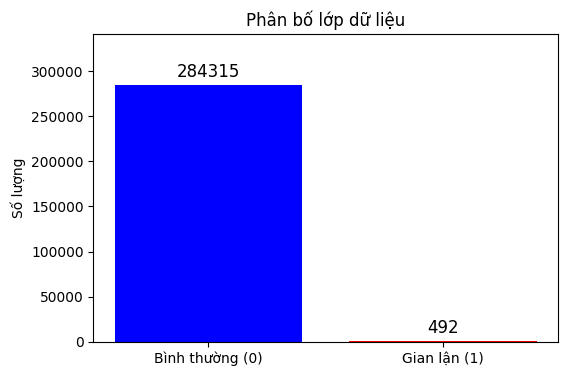

In [6]:
n_fraud = np.count_nonzero(labels == 1)
n_normal = np.count_nonzero(labels == 0)
total = len(labels)

fraud_percent = (n_fraud / total) * 100

print(f"Số giao dịch bình thường: {n_normal}")
print(f"Số giao dịch gian lận: {n_fraud}")
print(f"Tỷ lệ gian lận: {fraud_percent:.3f}%")

plt.figure(figsize=(6, 4))
bars = plt.bar(['Bình thường (0)', 'Gian lận (1)'], [n_normal, n_fraud], color=['blue', 'red'])
plt.title('Phân bố lớp dữ liệu')
plt.ylabel('Số lượng')
plt.bar_label(bars, fmt='%d', fontsize=12, padding=3)
plt.ylim(top=max(n_normal, n_fraud) * 1.2)
plt.show()

- Ta có thể thấy dữ liệu của chúng ta bị mất cân bằng nghiêm trọng. Do đó ta sẽ tiến hành áp dụng các loại kĩ thuật cân bằng dữ liệu

<h2 id="iii_2" style="font-weight: bold">2. Undersampling</h2>

Số lượng mẫu Gian lận: 492
Số lượng mẫu Bình thường (đã lấy mẫu): 492
Tổng số mẫu trong tập cân bằng: 984


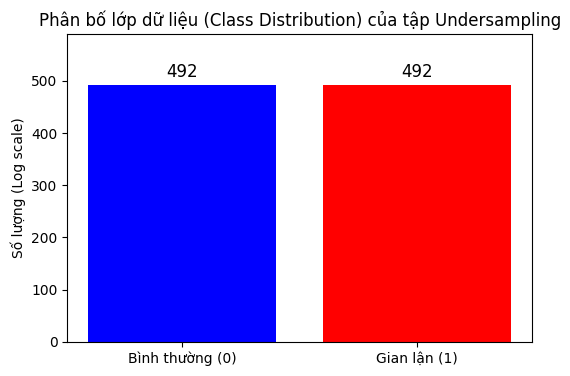

In [7]:
fraud_indices = np.where(labels == 1)[0]
normal_indices = np.where(labels == 0)[0]

rand_normal_indices = np.random.choice(normal_indices, size=len(fraud_indices), replace=False)

undersample_indices = np.concatenate([fraud_indices, rand_normal_indices])

# Xáo trộn index để dữ liệu không bị sắp xếp theo lớp
np.random.shuffle(undersample_indices)

X_sub = features_v[undersample_indices]
time_sub = scaled_time[undersample_indices]
amt_sub = scaled_amount[undersample_indices]
y_sub = labels[undersample_indices]

rebalanced_data = np.column_stack((time_sub, X_sub, amt_sub, y_sub))

print(f"Số lượng mẫu Gian lận: {len(fraud_indices)}")
print(f"Số lượng mẫu Bình thường (đã lấy mẫu): {len(rand_normal_indices)}")
print(f"Tổng số mẫu trong tập cân bằng: {len(undersample_indices)}")

plt.figure(figsize=(6, 4))
bars = plt.bar(['Bình thường (0)', 'Gian lận (1)'], [len(rand_normal_indices), len(fraud_indices)], color=['blue', 'red'])
plt.title('Phân bố lớp dữ liệu (Class Distribution) của tập Undersampling')
plt.ylabel('Số lượng (Log scale)')
plt.bar_label(bars, fmt='%d', fontsize=12, padding=3)
plt.ylim(top=max(len(rand_normal_indices), len(fraud_indices)) * 1.2)
plt.show()

<h2 id="iii_3" style="font-weight: bold">3. SMOTE</h2>

- Do SMOTE nên được áp dụng trong tập `train` để tránh việc bị `data leakage` do dữ liệu giả ta tạo ra bị đưa vào test và đồng thời giúp cho pipeline được mượt mà từ khâu áp dụng SMOTE đến khâu chia dữ liệu. Nên em sẽ implement SMOTE trong `02_preprocessing.ipynb`

**Kết luận:**

- Dữ liệu mất cân bằng nghiêm trọng. Gian lận chỉ chiếm 0.173% (492 mẫu) so với 284,315 mẫu bình thường. Điều này đặt ra yêu cầu phải sử dụng các kỹ thuật resampling (như Undersampling hoặc SMOTE) trước khi huấn luyện mô hình.

---

<h1 id="iv" style="font-weight: bold">IV. Khám phá đặc trưng Amount</h1>

Phân phối của số tiền giao dịch (Amount) có đặc điểm gì? Liệu các giao dịch gian lận có xu hướng xảy ra ở các khoản tiền lớn hay nhỏ?

<h2 id="iv_1" style="font-weight: bold">1. Thống kê cơ bản</h2>

In [8]:
print("--- Thống kê cột Amount ---")
print(f"Min: {np.min(amounts)}")
print(f"Max: {np.max(amounts)}")
print(f"Trung bình (Mean): {np.mean(amounts):.2f}")
print(f"Trung vị (Median): {np.median(amounts):.2f}")
print(f"Độ lệch chuẩn (Std): {np.std(amounts):.2f}")

percentiles = np.percentile(amounts, [25, 50, 75, 99])
print(f"25th percentile: {percentiles[0]}")
print(f"75th percentile: {percentiles[2]}")
print(f"99th percentile: {percentiles[3]}")

--- Thống kê cột Amount ---
Min: 0.0
Max: 25691.16
Trung bình (Mean): 88.35
Trung vị (Median): 22.00
Độ lệch chuẩn (Std): 250.12
25th percentile: 5.6
75th percentile: 77.16499999999999
99th percentile: 1017.9700000000012


**Nhận xét:**

**1. Phân bố nhãn (Bình thường vs Gian lận)**
- Tổng số giao dịch: 284,807

- Giao dịch bình thường: 284,315

- Giao dịch gian lận: 492

- Tỷ lệ gian lận chỉ ~0.173%, tức là mất cân bằng cực kỳ nghiêm trọng (imbalance ratio ~1:578).

**$\Rightarrow$ Ý nghĩa:**

- Các mô hình phân loại truyền thống sẽ dễ bị lệch về lớp "bình thường".

- Cần áp dụng:

    - Resampling (SMOTE, undersampling)

    - Anomaly detection (Isolation Forest, Autoencoder)

    - Thay đổi thang đo loss (class weight)

    - Dùng metric phù hợp: Precision, Recall, F1, AUC-PR thay vì Accuracy.

**2. Nhận xét về phân bố cột Amount**

- Phân bố lệch phải rất mạnh.

    - Mean >> median cho thấy dữ liệu bị kéo lên bởi một số lượng nhỏ giao dịch có giá trị khổng lồ.

- Phần lớn giao dịch có giá trị thấp

    - 75% giao dịch có số tiền dưới 77.

    - Điều này phù hợp với dữ liệu giao dịch thực tế: người dùng thanh toán các khoản nhỏ thường xuyên.

- Có một số giao dịch ngoại lệ

    - 1% cuối có Amount > 1,000.

    - Một vài giao dịch tới 25,000+ $\rightarrow$ ảnh hưởng tới training nếu không xử lý.

<h2 id="iv_2" style="font-weight: bold">2. Phân bố trong các lớp</h2>

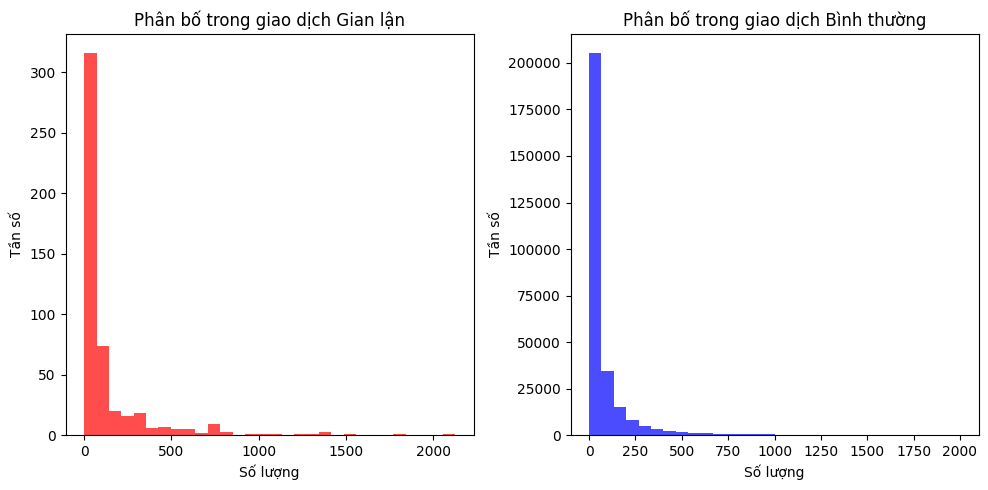

In [9]:
fraud_amounts = amounts[labels == 1]
normal_amounts = amounts[labels == 0]

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.hist(fraud_amounts, bins=30, color='red', alpha=0.7)
plt.title('Phân bố trong giao dịch Gian lận')
plt.xlabel('Số lượng')
plt.ylabel('Tần số')

plt.subplot(1, 2, 2)
plt.hist(normal_amounts, bins=30, color='blue', alpha=0.7, range=(0, 2000)) # Giới hạn range để dễ nhìn
plt.title('Phân bố trong giao dịch Bình thường')
plt.xlabel('Số lượng')
plt.ylabel('Tần số')

plt.tight_layout()
plt.show()

**Nhận xét:**  

**1. Cả hai phân bố đều lệch phải mạnh**

- Cả Gian lận lẫn Bình thường đều có dạng phân bố tương tự:

- Hầu hết giao dịch có số tiền rất nhỏ (dưới 100).

- Một số ít giao dịch có Amount cao bất thường $\rightarrow$ tạo ra đuôi dài.

$\Rightarrow$ Điều này phù hợp với thống kê trước đó (median rất thấp, mean bị kéo lên do outliers).

**2. Phân bố giao dịch bình thường rộng hơn rất nhiều**

- Giao dịch bình thường có số lượng lớn $\rightarrow$ tần số lớn.

- Gian lận thì ít (492 mẫu) nên tần số ít.

$\Rightarrow$ Điều này không phải vì phân bố khác biệt hoàn toàn, mà do fraud rất ít. (phù hợp với dữ liệu bị mất cân bằng nghiêm trọng mà ta đã phát hiện ở trước)

**3. Gian lận không tập trung vào khoản tiền cao**

- Gian lận có nhiều giao dịch nằm ở mức thấp (< 100).

- Số lượng fraud ở mức cao (1000–2000) rất ít.

$\Rightarrow$ Gian lận không nhất thiết xảy ra ở giao dịch lớn. Ngược lại, scammer thường thực hiện những giao dịch nhỏ để tránh bị phát hiện sớm.

**4. Tuy nhiên, Gian lận có nhiều giá trị "dị biệt" hơn**

- Trong biểu đồ Gian lận, vẫn có vài mức Amount:

    - 500

    - 1000

    - 1500

    - 2000

$\Rightarrow$ Có thể là các giao dịch bất thường có giá trị cao hơn mức thông thường.

**Kết luận:**

- Phân phối lệch phải mạnh. Phần lớn các giao dịch gian lận tập trung vào số tiền nhỏ (dưới 100 đơn vị), trái ngược với suy nghĩ thông thường là kẻ gian lận sẽ rút số tiền lớn. Đồng thời xuất hiện nhiều giá trị ngoại lai (outliers) lớn trong dữ liệu.

---

<h1 id="v" style="font-weight: bold">V. Khám phá đặc trưng Thời gian</h1>

Yếu tố thời gian (Time) có cho thấy quy luật hoạt động khác biệt giữa hành vi gian lận và bình thường không?

<h2 id="v_1" style="font-weight: bold">1. Thống kê cơ bản</h2>

In [10]:
print("--- Thống kê cột Times ---")
print(f"Min: {np.min(times)}")
print(f"Max: {np.max(times)}")
print(f"Trung bình (Mean): {np.mean(times):.2f}")
print(f"Trung vị (Median): {np.median(times):.2f}")
print(f"Độ lệch chuẩn (Std): {np.std(times):.2f}")

percentiles = np.percentile(times, [25, 50, 75, 99])
print(f"25th percentile: {percentiles[0]}")
print(f"75th percentile: {percentiles[2]}")
print(f"99th percentile: {percentiles[3]}")

--- Thống kê cột Times ---
Min: 0.0
Max: 172792.0
Trung bình (Mean): 94813.86
Trung vị (Median): 84692.00
Độ lệch chuẩn (Std): 47488.06
25th percentile: 54201.5
75th percentile: 139320.5
99th percentile: 170560.94


**Nhận xét:**

**1. Time trải dài toàn bộ khoảng thời gian ghi nhận dữ liệu**

- Min = 0s $\rightarrow$ giao dịch đầu tiên.

- Max = ~172,792s $\approx$ 48 giờ.
→ Khớp với mô tả của dataset: dữ liệu được thu thập trong 2 ngày.

Điều này chứng tỏ giá trị Time đúng với bối cảnh và không có giá trị âm hoặc thiếu logic.

**2. Phân bố Time khá rộng nhưng không đồng nhất**

- Median = 84,692

- Mean = 94,813

- 25% dữ liệu trước 54,201s (~15 giờ)

- 75% dữ liệu trước 139,320s (~38 giờ)

$\Rightarrow$ Time không phân bố đều → có những thời điểm giao dịch dồn nhiều hơn.

**3. Mean > Median $\rightarrow$ phân bố hơi lệch phải**

- Có xu hướng hơi lệch sang phía các thời điểm muộn hơn.

- Điều này có thể do ngày thứ hai có nhiều giao dịch hơn ngày đầu.

<h2 id="v_2" style="font-weight: bold">2. Phân bố trong các lớp</h2>

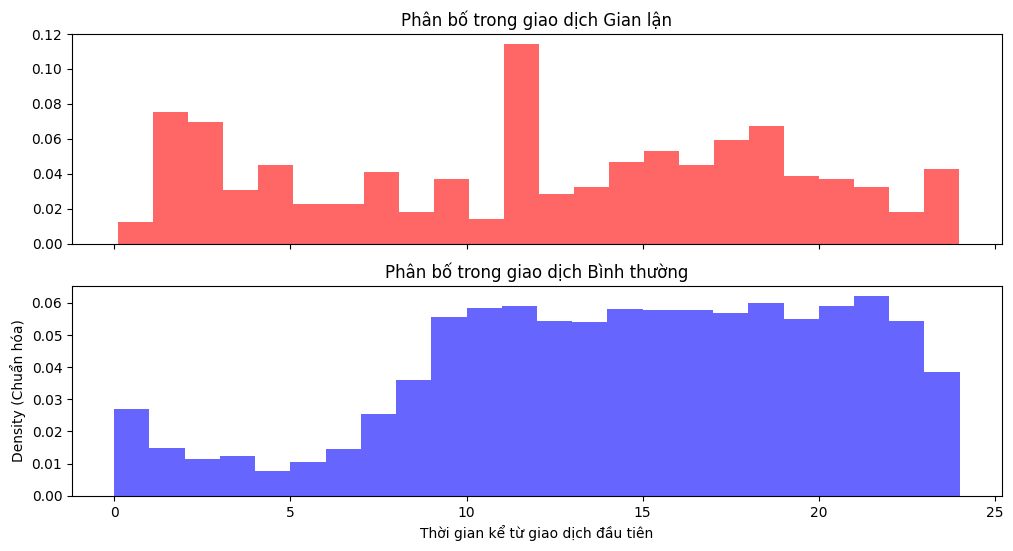

In [11]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12, 6))

# Chuyển đổi Time (giây) sang Giờ (Hour) để dễ nhìn (2 ngày dữ liệu)
# 1 ngày = 24 * 3600 = 86400 giây
time_hours = times / 3600 % 24 

# (1) Histogram Time theo Class
ax1.hist(time_hours[labels == 1], bins=24, color='red', alpha=0.6, density=True)
ax1.set_title('Phân bố trong giao dịch Gian lận')

ax2.hist(time_hours[labels == 0], bins=24, color='blue', alpha=0.6, density=True)
ax2.set_title('Phân bố trong giao dịch Bình thường')

plt.xlabel('Thời gian kể từ giao dịch đầu tiên')
plt.ylabel('Density (Chuẩn hóa)')
plt.show()

**Nhận xét**

**1. Giao dịch Gian lận**

- Phân bố rời rạc, không có quy luật

- Phân bố rất không đồng đều theo thời gian trong ngày.

- Một số giờ có đỉnh bất thường (khu vực khoảng giờ thứ 10 có một spike rất cao, còn nhiều giờ lại gần như bằng 0).

- Điều này cho thấy:

    - Scammer không tuân theo hành vi sinh hoạt tự nhiên (như ban ngày nhiều giao dịch, đêm ít giao dịch).
    
    - Các giao dịch gian lận có thể xảy ra ngẫu nhiên, hoặc tại các khung giờ thuận lợi cho tấn công (ví dụ: thời điểm hệ thống ít người theo dõi, giờ ít giao dịch thật…).

**2. Giao dịch Bình thường**

– Có quy luật rõ ràng theo thời gian trong ngày

- Giao dịch bình thường có dạng phân bố tự nhiên, với mật độ tăng dần khi tiến tới ban ngày.

- Có xu hướng:

    - Ít giao dịch vào đêm/tờ sáng (0–6 giờ)

    - Tăng mạnh từ 8 giờ → cuối buổi chiều

    - Giảm nhẹ vào buổi tối (sau 20h)

$\rightarrow$ Đây là phân bố hợp lý vì giao dịch tài chính của người dùng có tính chu kỳ theo hoạt động trong ngày.

**Kết luận:**

- Giao dịch bình thường tuân theo quy luật sinh hoạt (ít vào ban đêm, tăng vào ban ngày). Ngược lại, giao dịch gian lận phân bố rải rác và không tuân theo chu kỳ ngày đêm rõ rệt, cho thấy scammer hoạt động bất kể thời gian hoặc lợi dụng lúc hệ thống ít được giám sát.

---

<h1 id="vi" style="font-weight: bold">VI. Tương quan giữa các đặc trưng</h1>

Tại sao việc xem xét ma trận tương quan trên tập dữ liệu gốc lại không hiệu quả? Những đặc trưng ẩn (V1-V28) nào có mối liên hệ mạnh nhất (cả tích cực và tiêu cực) với hành vi gian lận?

<h2 id="vi_1" style="font-weight: bold">1. Ma trận tương quan trên tập dữ liệu gốc</h2>

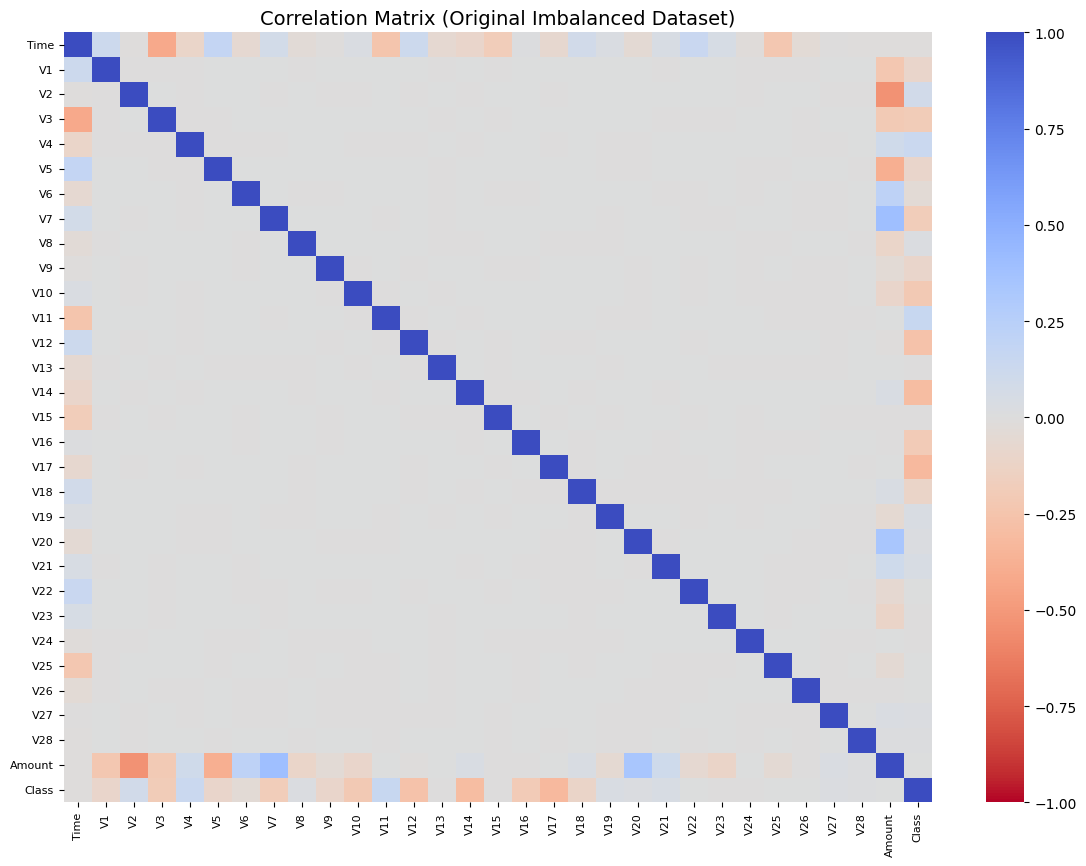

In [12]:
X_original = np.column_stack((scaled_time, features_v, scaled_amount, labels))

# 2. Tính ma trận tương quan trên toàn bộ dữ liệu
# Hàm np.corrcoef trả về ma trận tương quan của các biến
corr_matrix_origin = np.corrcoef(X_original, rowvar=False)

# 3. Trực quan hóa
plt.figure(figsize=(14, 10))

# Vẽ Heatmap
sns.heatmap(corr_matrix_origin, cmap='coolwarm_r', annot=False, fmt='.1f', vmin=-1, vmax=1)
plt.title('Correlation Matrix (Original Imbalanced Dataset)', fontsize=14)

# Gán nhãn trục cho dễ nhìn
col_names = ['Time'] + [f'V{i}' for i in range(1, 29)] + ['Amount', 'Class']
# Đặt ticks ở giữa các ô
ticks = np.arange(len(col_names)) + 0.5
plt.xticks(ticks, col_names, rotation=90, fontsize=8)
plt.yticks(ticks, col_names, rotation=0, fontsize=8)

plt.show()

**Nhận xét:**

**1. Đa số các biến gần như không tương quan**

- Ngoại trừ đường chéo (tương quan = 1 với chính nó), hầu hết các ô đều rất nhạt $\rightarrow$ tức là hệ số tương quan gần 0.

**2. Một số biến có tương quan yếu với "Class"**

- Mặc dù yếu (|correlation| < 0.4), vẫn có những biến “có tín hiệu”:

- Một vài biến như V3, V4, V10, V11, V12, V14, V17 có tương quan âm hoặc dương nhẹ với Class.

$\rightarrow$ Không có feature nào tương quan mạnh → gian lận không phân biệt rõ ràng bằng tuyến tính

**3. `Amount` có tương quan nhẹ với nhiều PC**

- Nó tương quan nhẹ với một số Vx (không phải vấn đề).

- Tương quan với Class vẫn thấp $\rightarrow$ gian lận không chỉ xảy ra ở giao dịch lớn.

$\Rightarrow$ Không thể đơn giản gắn nhãn fraud = giao dịch có Amount cao.

**4. `Time` gần như không cung cấp thông tin cho tương quan tuyến tính**

Feature Time có tương quan gần như 0 với:

- Các PC (V1–V28)

- Class

Distribution time giữa fraud và non-fraud không mang tính tuyến tính.

`Time` không hữu ích khi nhìn theo dạng linearly correlated.

**Kết luận:**

- Do vấn đề mất cân bằng dữ liệu nghiêm trọng nên các đặc trưng không có mối tương quan mạnh với nhau. Khiến cho việc xác định các đặc trưng quan trọng trở nên khó khăn.

- Do đó ta sẽ kiểm tra lại ma trận tương quan trên tập dữ liệu đã được áp dụng kĩ thuật undersampling.

<h2 id="vi_2" style="font-weight: bold">2. Ma trận tương quan trên tập dữ liệu cân bằng</h2>

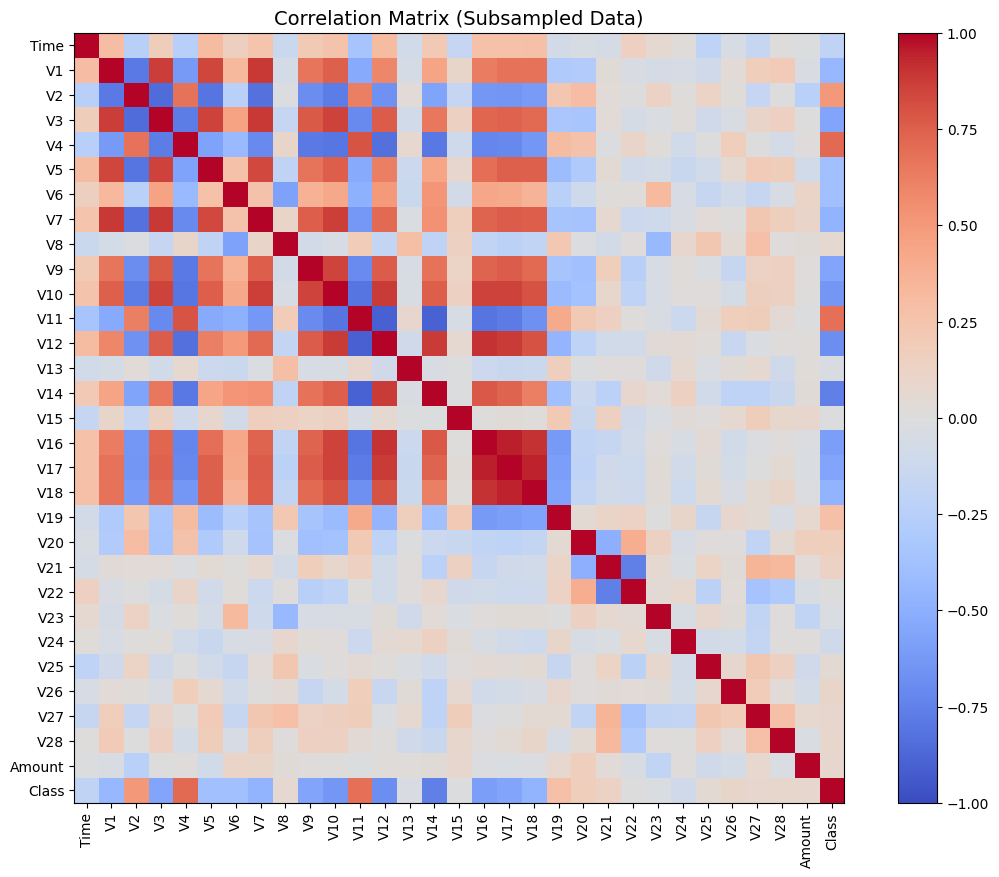

In [13]:
# Tính ma trận tương quan
# rowvar=False nghĩa là mỗi cột là một biến số
corr_matrix = np.corrcoef(rebalanced_data, rowvar=False)

# Vẽ Heatmap bằng Matplotlib
plt.figure(figsize=(14, 10))
plt.imshow(corr_matrix, cmap='coolwarm', interpolation='nearest', vmin=-1, vmax=1)
plt.colorbar()
plt.title('Correlation Matrix (Subsampled Data)', fontsize=14)

# Gán nhãn trục (Labels)
ticks = np.arange(len(col_names))
plt.xticks(ticks, col_names, rotation=90)
plt.yticks(ticks, col_names)

plt.show()

**Nhận xét:**

**1. Các thành phần PCA (V1–V28)**

- Chúng có xu hướng ít tương quan mạnh với nhau (mục tiêu của PCA là giảm tương quan giữa các chiều).

- Tuy nhiên, ta vẫn có thể thấy một số vùng đỏ lớn $\rightarrow$ các thành phần PCA không hoàn toàn độc lập, điều này bình thường nếu PCA không giữ toàn bộ phương sai hoặc nếu trước khi PCA các biến vẫn còn cấu trúc phức tạp.

- Một số cụm có tương quan mạnh (dương hoặc âm), ví dụ:

    - V10–V17 có nhiều điểm đỏ đậm $\rightarrow$ chúng chứa thông tin chung nào đó liên quan đến cấu trúc biến đổi của dữ liệu.

    - Một số cặp như V3–V10, V4–V11, V5–V12 cũng xuất hiện mô hình lặp lại $\rightarrow$ có thể là hiệu ứng của PCA xoay quanh cùng cụm đặc trưng gốc.

**2. Tương quan với biến Class**

- Hầu hết các biến có tương quan rất nhỏ với Class, đây là đặc điểm thường thấy trong dataset fraud:

- Gian lận thường rất tinh vi $\rightarrow$ không tạo ra tương quan tuyến tính rõ ràng với các biến.

Nhưng ta có thể thấy:

- Một số đặc trưng PCA có tương quan nhẹ với Class (ví dụ: V4, V10, V14, V17 tùy từng dataset).

- Điều này cho thấy các thành phần PCA đó chứa thông tin hữu ích phân biệt giao dịch bình thường với gian lận.

**3. Biến Time và Amount**

- Time: tương quan yếu $\rightarrow$ gian lận không xảy ra tại một thời điểm cố định.

- Amount: có một chút tương quan với một số thành phần PCA, nhưng rất yếu với Class $\rightarrow$ gian lận không chỉ phụ thuộc vào giá trị giao dịch.

**Kết luận:**

- PCA đã giảm tương quan nhưng không loại bỏ hoàn toàn → xuất hiện nhiều cụm tương quan.

- Đa số biến có tương quan rất thấp với Class → phù hợp với bản chất bài toán fraud.

- Undersampling đã giúp tăng nhẹ độ nổi bật của một số features.

- Điều này cho thấy ta không nên dựa vào tương quan tuyến tính để chọn feature, mà nên dùng:

    - Feature importance từ Random Forest / XGBoost

    - Mutual information

    - Model tree-based

    - SHAP values

- Hoặc ta có thể dùng kĩ thuật giảm chiều dữ liệu và gom cụm để kiểm tra xem việc phân biệt có tốt hơn không

In [14]:
# In ra các feature có tương quan mạnh nhất với Class (cột cuối cùng)
# Cột cuối cùng là index 30
corr_with_class = corr_matrix[:-1, 30] # Bỏ tương quan với chính nó

print("Top 3 Tương quan Âm (Negative):")
neg_idx = np.argsort(corr_with_class)[:4]
for idx in neg_idx:
    print(f"{col_names[idx]}: {corr_with_class[idx]:.3f}")

print("\nTop 3 Tương quan Dương (Positive):")
pos_idx = np.argsort(corr_with_class)[-4:]
for idx in pos_idx:
    print(f"{col_names[idx]}: {corr_with_class[idx]:.3f}")


Top 3 Tương quan Âm (Negative):
V14: -0.752
V12: -0.680
V10: -0.633
V16: -0.597

Top 3 Tương quan Dương (Positive):
V19: 0.277
V2: 0.502
V11: 0.686
V4: 0.707


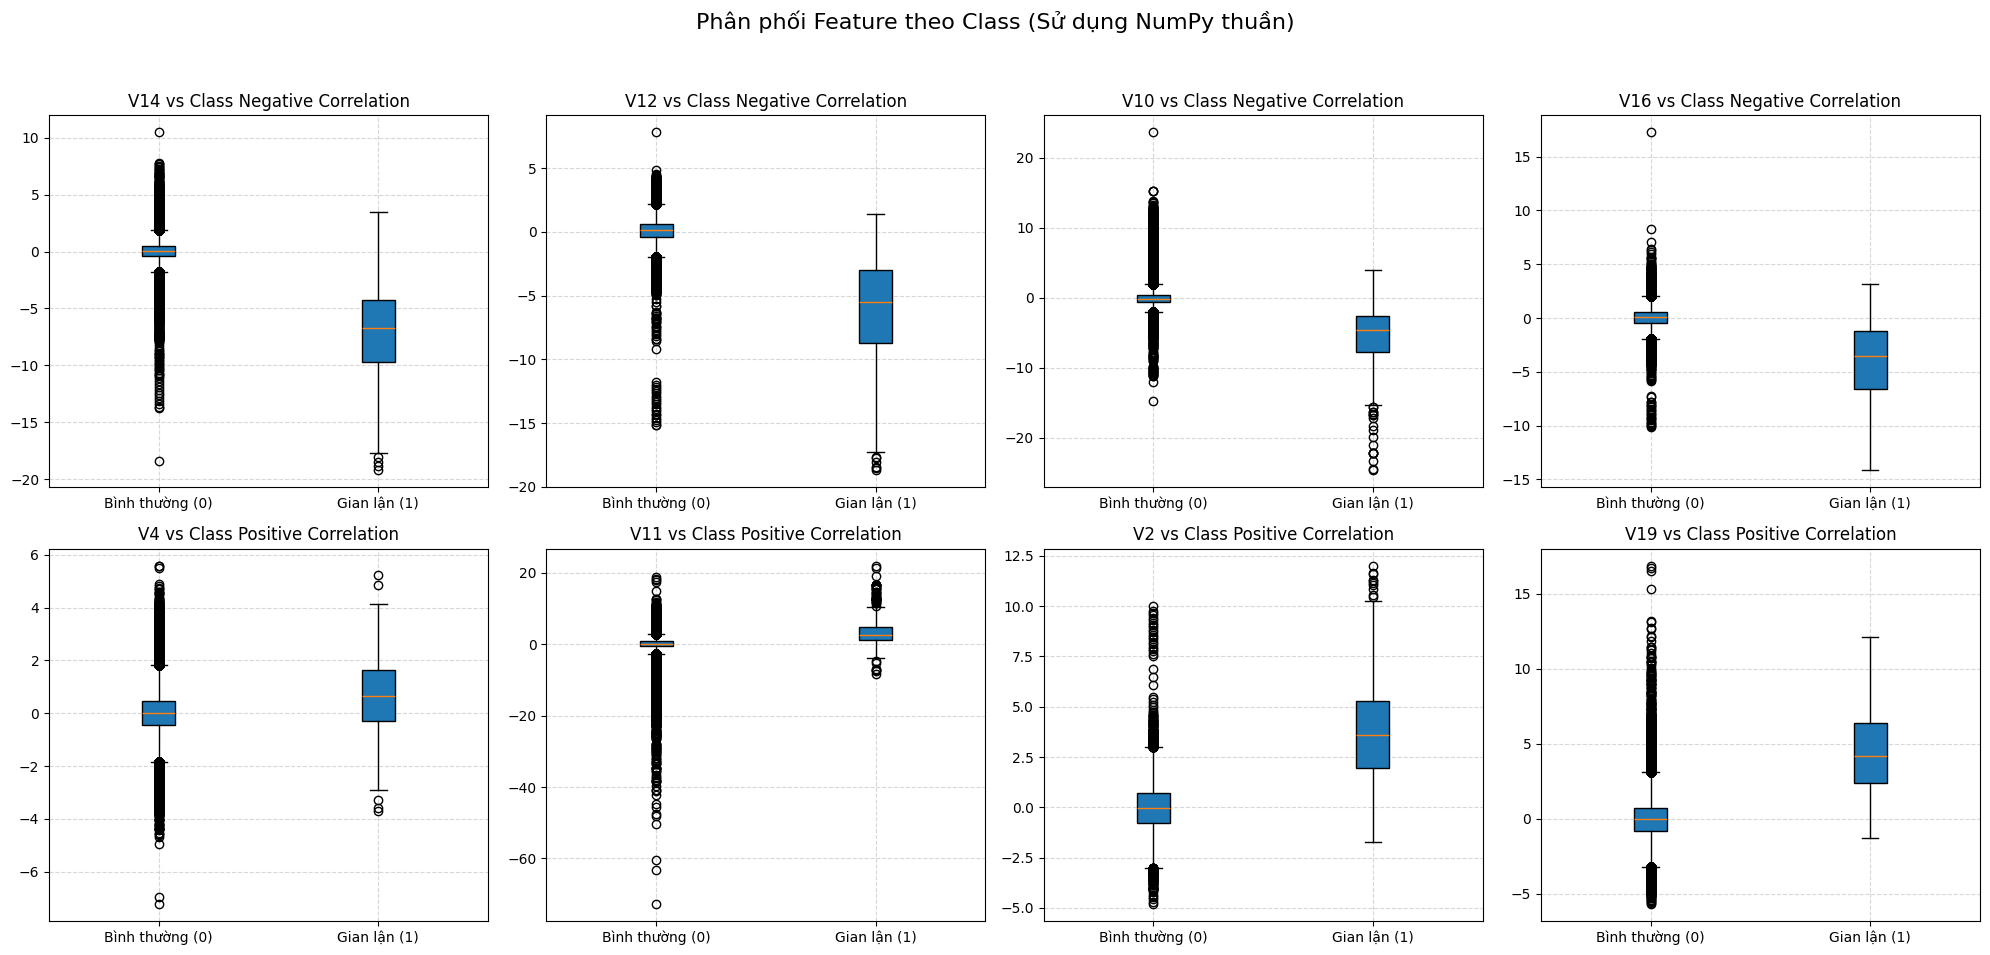

In [15]:
normal_data = data[labels == 0] 
fraud_data = data[labels == 1]

# Feature Tương quan Âm (Negative)
neg_features_names = ['V14', 'V12', 'V10', 'V16']

# Feature Tương quan Dương (Positive)
pos_features_names = ['V4', 'V11', 'V2', 'V19']

# --- 3. VẼ BIỂU ĐỒ ---
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
plt.suptitle('Phân phối Feature theo Class (Sử dụng NumPy thuần)', fontsize=16)

# Hàm vẽ phụ trợ để đỡ lặp code
def plot_box_numpy(ax, feature_idx, feature_name, is_neg = True):
    vec_normal = normal_data[:, feature_idx]
    vec_fraud = fraud_data[:, feature_idx]
    
    ax.boxplot([vec_normal, vec_fraud], tick_labels=['Bình thường (0)', 'Gian lận (1)'], patch_artist=True)
    title = f'{feature_name} vs Class Negative Correlation' if is_neg else f'{feature_name} vs Class Positive Correlation'
    ax.set_title(title)
    ax.grid(True, linestyle='--', alpha=0.5)

for i, (idx, name) in enumerate(zip(neg_idx, neg_features_names)):
    plot_box_numpy(axes[0, i], idx, name)

for i, (idx, name) in enumerate(zip(pos_idx, pos_features_names)):
    plot_box_numpy(axes[1, i], idx, name, False)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

**Nhận xét:**

**1. Nhóm Tương Quan Âm (V14, V12, V10, V16)**

- `V14` - phân tách mạnh nhất

    - Bình thường: quanh mức 0, trải dài từ khoảng -10 đến +10.

    - Gian lận: tập trung mạnh ở vùng rất âm (-15 đến -5).

    - Trung vị của Gian lận âm sâu so với Bình thường.

    $\rightarrow$ `V14` là feature phân biệt fraud tốt nhất trong nhóm này. Đúng với kết quả correlation (-0.747).

- `V12` - phân tách rõ và khá mạnh

    - Bình thường: quanh mức 0.

    - Gian lận: dịch toàn bộ sang trái (âm), tương tự V14 nhưng bớt cực đoan.

    - Trung vị Gian lận âm rõ rệt hơn Bình thường.

    $\rightarrow$ `V12` cũng là feature rất mạnh, cấu trúc gian lận thể hiện rõ ở vùng âm.

- `V10` - phân tách tốt, nhưng có nhiều outlier

    - Bình thường: giá trị phân tán rộng, nhiều outlier dương (đến 20+).

    - Gian lận: tập trung âm nhưng bề rộng lớn $\rightarrow$ phân phối nhiều nhiễu.

    - Trung vị: Gian lận vẫn nghiêng âm rõ rệt.

    $\rightarrow$ `V10` có khả năng phân tách tốt, nhưng nhiều outlier $\rightarrow$ phù hợp cho model phi tuyến.

- `V16` — phân tách khá tốt

    - Bình thường: quanh mức 0, hơi lệch về âm nhưng nhẹ.

    - Gian lận: trung vị âm và trải dài sâu hơn.

    - Mặc dù gap không lớn như `V14`/`V12`, nhưng trend rất rõ.

    $\rightarrow$ `V16` vẫn là feature tốt, nhưng mức phân tách không cực mạnh.

**2. Nhóm Tương Quan Dương (V4, V11, V2, V19)**

- `V4` - dương mạnh nhất

    - Bình thường: quanh 0, phân bố hẹp.

    - Gian lận: dịch hoàn toàn về vùng dương, trung vị rõ ràng cao hơn.

    - Tách biệt khá tốt.

    $\rightarrow$ `V4` là best positive feature, hỗ trợ phân loại fraud rõ rệt.

- `V11` - phân bố đặc biệt

    - Bình thường: giá trị phân tán rất rộng (từ -60 đến +20), nhiều outliers.

    - Gian lận: tập trung chủ yếu vùng dương, phân bố hẹp hơn.

    - Trung vị Gian lận cao hơn Bình thường rất nhiều.

    $\rightarrow$ `V11` có giá trị phân tách tốt, nhưng Bình thường quá phân tán $\rightarrow$ có thể gây noise cho model tuyến tính.

- `V2` - phân tách trung bình

    - Gian lận có trung vị cao hơn Bình thường.

    - Nhưng hai boxplot vẫn chồng lấp khá nhiều.

    $\rightarrow$ `V2` là feature hỗ trợ nhưng không mạnh.

- `V19` — phân tách yếu nhất

    - Gian lận hơi dịch sang dương nhưng chồng lấp nhiều với Bình thường.

    - Khoảng phân bố hai nhóm khá giống nhau.

    $\rightarrow$ V19 không phải feature quan trọng, chỉ mang tính bổ sung.

**Kết luận:**

- Nhóm âm mạnh hơn nhóm dương $\rightarrow$ đúng với bản chất dữ liệu fraud.

- Top Feature Overall: 
    - V14
    - V12
    - V10
    - V4
    - V11

- Trên tập dữ liệu gốc (mất cân bằng), các mối tương quan rất mờ nhạt do lớp Normal chiếm ưu thế. Tuy nhiên, khi Undersampling, ta thấy rõ các biến V14, V12, V10 có tương quan âm mạnh (giá trị càng thấp càng dễ là gian lận) và V4, V11 có tương quan dương mạnh với Class.

---

<h1 id="vii" style="font-weight: bold">VII. Phân cụm</h1>

Liệu có thể phân tách rõ ràng các giao dịch gian lận và bình thường trong không gian chiều thấp không? Phương pháp giảm chiều dữ liệu nào hiệu quả nhất?

Ta tiến hành phân cụm ngay trên tập dữ liệu đã được undersampling.


--- Running ---

--- Running Truncated ---

--- Running t-SNE ---
t-SNE: Đang tính ma trận P...
t-SNE: Bắt đầu 500 vòng lặp...
  Vòng 100: Tắt early exaggeration
  Vòng 100, Error: 2.3261
  Vòng 200, Error: 0.9222
  Vòng 300, Error: 0.8330
  Vòng 400, Error: 0.7995


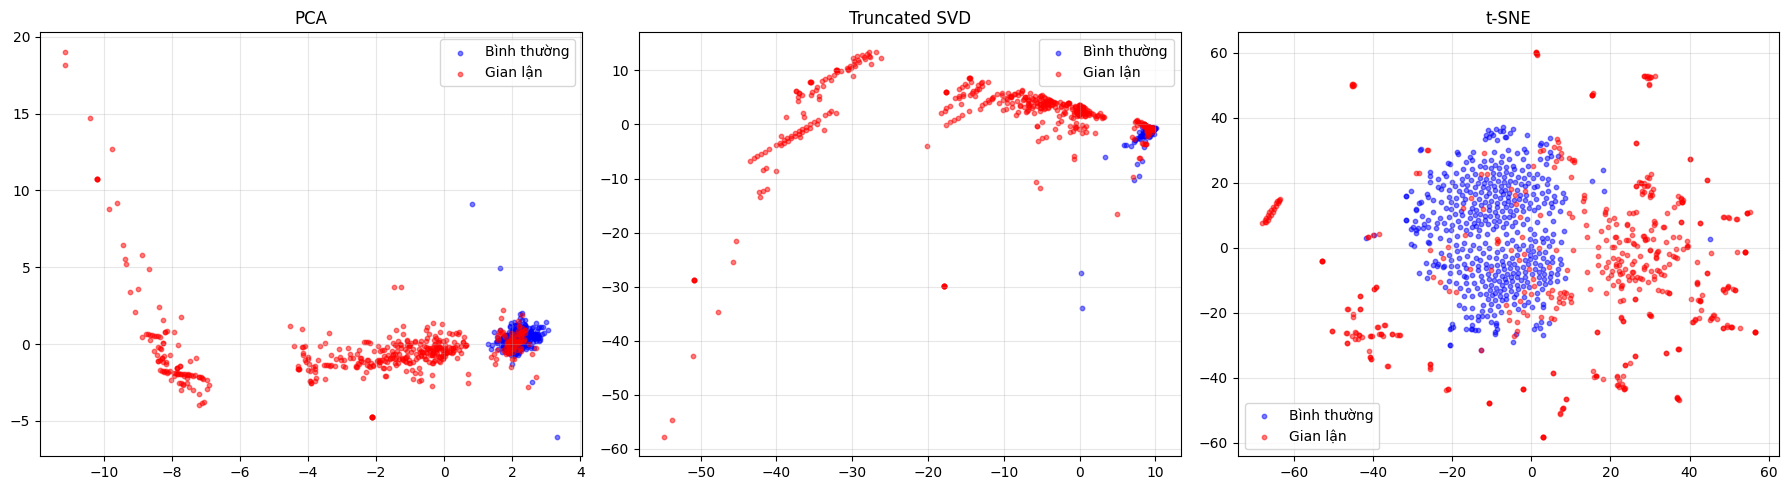

In [16]:
X = rebalanced_data[:, :-2]
y = rebalanced_data[:, -1]

# 1. Chạy PCA
print("\n--- Running ---")
X_pca = numpy_pca(X)

# 2. Chạy Truncated SVD
print("\n--- Running Truncated ---")
X_svd = numpy_truncated_svd(X)

# 3. Chạy t-SNE
print("\n--- Running t-SNE ---")
# Giảm chiều xuống 30 bằng PCA trước khi vào t-SNE là mẹo hay dùng để giảm nhiễu và tăng tốc
X_pca_50 = numpy_pca(X, n_components=20) 
X_tsne = numpy_tsne(X_pca_50, n_iter=500, learning_rate=200)

# --- VẼ BIỂU ĐỒ SO SÁNH ---
plt.figure(figsize=(18, 5))

def plot_scatter(ax, X, title):
    ax.scatter(X[y==0, 0], X[y==0, 1], c='blue', label='Bình thường', alpha=0.5, s=10)
    ax.scatter(X[y==1, 0], X[y==1, 1], c='red', label='Gian lận', alpha=0.5, s=10)
    ax.set_title(title)
    ax.legend()
    ax.grid(True, alpha=0.3)

# Plot PCA
ax1 = plt.subplot(1, 3, 1)
plot_scatter(ax1, X_pca, "PCA")

# Plot SVD
ax2 = plt.subplot(1, 3, 2)
plot_scatter(ax2, X_svd, "Truncated SVD")

# Plot t-SNE
ax3 = plt.subplot(1, 3, 3)
plot_scatter(ax3, X_tsne, "t-SNE")

plt.tight_layout()
plt.show()

**Nhận xét:**  

**1. PCA**

- Phân bố điểm cho Gian lận (đỏ) và Bình thường (xanh) chồng lấn nhiều, đặc biệt ở cụm phía bên phải.

- PCA giữ các hướng có phương sai lớn nhất → nhưng fraud/normal không khác nhau theo phương sai tuyến tính, nên PCA không tách được tốt.

- Cụm Gian lận kéo dài theo một đường cong → có thể do dữ liệu biến đổi phi tuyến hoặc có tương tác phức tạp giữa các features.

    $\rightarrow$ Không tách được hai lớp rõ ràng

**2. Truncated SVD**

- Biểu đồ cho thấy SVD thể hiện phân bố “xiên” và kéo giãn bất thường, có thể do:

    - scale dữ liệu khác nhau,

    - thiếu chuẩn hóa trước khi giảm chiều,

    - hoặc ma trận có cấu trúc đặc biệt (nhiều giá trị gần 0).

- Gian lận và Bình thường cũng không tách biệt, tương tự PCA.

    $\rightarrow$ Không cải thiện so với PCA, thậm chí giảm chất lượng trực quan.

**3. t-SNE**

- t-SNE tạo thành 2 vùng khá rõ:

    - Một cụm Bình thường (xanh) tương đối gọn, rõ ràng.

    - Gian lận (đỏ) phân tán nhiều hướng, hình thành các cụm nhỏ.

- Điều này phù hợp với bản chất của fraud:

    - Gian lận thường rất đa dạng và rải rác → khó gom cụm.

    - Bình thường thì mang dạng “hành vi chuẩn” → tạo cluster chắc chắn hơn.

- t-SNE là phương pháp phi tuyến nên nó khai phá được cấu trúc phức tạp mà PCA/SVD không thấy.

    $\rightarrow$ Tách tốt hơn PCA và SVD. Lộ rõ cấu trúc nội tại: Bình thường và Gian lận không cùng phân bố.

**Kết luận**

- Các phương pháp tuyến tính như PCA và Truncated SVD không tách biệt tốt hai lớp dữ liệu (chúng vẫn chồng lấn lên nhau). Tuy nhiên, t-SNE (phương pháp phi tuyến) cho thấy khả năng gom cụm rất tốt, tách biệt rõ ràng nhóm Fraud và Normal.

---

<h1 id="viii" style="font-weight: bold">VIII. Tham khảo</h1>

[Credit Fraud || Dealing with Imbalanced Datasets - Janio Martinez Bachmann](https://www.kaggle.com/code/janiobachmann/credit-fraud-dealing-with-imbalanced-datasets)